# **IMPORT LIBRARIES**

In [ ]:
from textblob import TextBlob 
import matplotlib.pyplot as plt
import pandas as pd
import re 
import nltk
import string
from nltk.corpus import stopwords
import seaborn as sns
import pylab as plt
import statsmodels.api as sm
import numpy as np
from tqdm.notebook import tqdm_notebook
import time
from wordcloud import WordCloud
!pip install yfinance --quiet
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

path = '/SENTIMETER'

Mounted at /content/drive


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# **FUNCTIONS**

In [ ]:
def CleanTweets(twt):
    twt = twt.lower()                        # Tutto in minuscolo
    twt = re.sub('#bitcoin', 'bitcoin', twt) # BTC
    twt = re.sub('\\n', '', twt)             # Cancella newline string (\\n)
    twt = re.sub('@[^\s]+', '', twt)         # Cancella username
    twt = re.sub(r'http\S+', '', twt)        # Cancella hyperlink
    twt = re.sub(r'https\S+', '', twt)       # Cancella hyperlink
    twt = re.sub(r'don\'t', 'do not', twt)  
    twt = re.sub(r'dont', 'do not', twt)
    twt = re.sub(r'doesn\'t', 'does not', twt)  
    twt = re.sub(r'haven\'t', 'have not', twt) 
    twt = re.sub(r'that\'s', 'that is', twt) 
    twt = re.sub(r'doesnt', 'does not', twt) 
    twt = re.sub(r'can\'t', 'can not', twt)   
    twt = re.sub(r'wont', 'will not', twt) 
    twt = re.sub(r'it\'s', 'it is', twt)   
    twt = re.sub(r"'ve\b", " have", twt)
    twt = re.sub(r"'ll\b", " will", twt)
    twt = re.sub(r'i\'m', 'i am', twt)
    # remove user handle
    twt = re.sub("@[\w]*", "", twt)
    # remove digits and spl characters
    twt = re.sub("[^a-zA-Z#]", " ", twt)
    # remove additional spaces
    twt = re.sub("\s+", " ", twt) 
    #twt = re.sub(r'\b\d+\b', '', twt) #tolgo i singoli token che sono numeri.The regular expression pattern \b\d+\b matches strings that consist of one or more digits surrounded by word boundaries. Word boundaries ensure that only full words consisting of digits are matched and not just digits within larger words.
    return twt

def RemovePunctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def RemoveTweetWithToken(df, column, token):
    mask = df[column].str.contains(r'\b{}\b'.format(token), case=False)
    return df[~mask]

def GetTweetWith2Tokens(df, column, token1, token2):
    mask = df[column].str.contains(r'\b{}\b'.format(token1), case=False) | df[column].str.contains(r'\b{}\b'.format(token2), case=False)
    return df[mask]

def RemoveAMP(df):
  mask = df['Tweet'].str.contains(r' &amp; ')
  return df[~mask]

def RemoveTweetWith2TokenS(df, column, token1, token2):
  mask = df[column].str.contains(r'\b{}\b'.format(token1), case=False)&df[column].str.contains(r'\b{}\b'.format(token2), case=False)
  return df[~mask]

def RemoveTweetsWithLongWords(df, lunghezza): 
  df['check_len'] = 1 
  j = 0
  for i in tqdm_notebook(range (0,len(df['Tweet']))):
    tweet = df['Tweet'][i].split()
    for word in tweet:
      if len(word) > lunghezza:
        df['check_len'][i] = 0
        j += 1
  print('Tweet rimossi per parole troppo lunghe:',j)
  df = df[(df.check_len == 1)] #li elimino
  del df['check_len']
  return df

def RemoveTweetsWithMoreThanKWords(df, parole): 
  df['Numero_parole'] = df['Tweet'].str.split().str.len() 
  df = df[(df.Numero_parole > parole)] 
  del df['Numero_parole'] 
  return df

def RemoveStopwords(df): 
  nltk.download('stopwords') 
  stop_words = set(stopwords.words('english')) 
  df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
  return df

def WordCount(colonna):
  all_tweets = ' '.join(colonna.tolist())# Combining all tweets into one string
  # Removing URLs, mentions, hashtags, and non-alphanumeric characters except spaces
  all_tweets = re.sub(r'http\S+|www\S+|https\S+|@[^\s]+|#|[^A-Za-z0-9\s]+', '', all_tweets)
  all_tweets = all_tweets.lower()
  # Splitting the string into words
  words = all_tweets.split()
  # Counting the frequency of each word and creating a dictionary
  word_count = {}
  for word in words:
      if word not in word_count:
          word_count[word] = 1
      else:
          word_count[word] += 1
  # Creating a dataframe of the most frequent words and sorting them by frequency
  top_words = pd.DataFrame(sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:100], columns=['Word', 'Frequency'])
  return top_words

def Wordcloud(frequency_df):
    data = frequency_df.set_index('Word').to_dict()['Frequency']
    wordcloud = WordCloud(width=600, height=300, background_color='white', max_words=200, max_font_size=100, colormap='winter').generate_from_frequencies(data)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity
  
def getPolarity(text):
  return TextBlob(text).sentiment.polarity
 
def getSentiment(score):
  if score < -0.1:
    return 'NEGATIVE'
  elif score > 0.1:
    return 'POSITIVE'
  else:
    return 'NEUTRAL'

# Define a function to calculate the modified polarity score for each tweet based on custom words and values
def custom_polarity(tweet):
    # Use TextBlob to get the original polarity score for the tweet
    blob = TextBlob(tweet)
    original_polarity = blob.sentiment.polarity
    
    # Modify the polarity score based on custom words and values
    if "bullish" in tweet:
        modified_polarity = original_polarity + 0.1
    elif "bearish" in tweet:
        modified_polarity = original_polarity - 0.1
    else:
        modified_polarity = original_polarity
    
    return modified_polarity

def Flair(text):
  sentence = Sentence(text)
  classifier.predict(sentence)
  score = sentence.labels[0].score
  value = sentence.labels[0].value
  return score, value

# **READ DATA**

## SPAM

In [ ]:
spam = pd.read_csv(f'{path}/SPAM.csv')
spam = spam[['Tweet','Type']]
spam

,Tweet,Type
0,Good Morning Love @LeeBrown_V,Quality
1,'@realDonaldTrump @USNavy RIP TO HEROES',Spam
2,Haven't been following the news but I understa...,Quality
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,Quality
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,Quality
...,...,...
14894,"#AllWentWrongWhen I told my hair stylist to ""g...",Spam
14895,"They don't have to like you, and you don't hav...",Quality
14896,#Miami Graham Nash Live at Parker Playhouse #...,Spam
14897,@bethannhamilton is in the business of one-upp...,Quality


In [ ]:
spam.Type.value_counts()

Quality         7454
Spam            7443
South Dakota       2
Name: Type, dtype: int64

In [ ]:
import nltk
nltk.download('punkt')

 # create dataframe for Type = "Quality"
quality_df = spam[spam["Type"] == "Quality"]
quality_tweets = quality_df['Tweet'].tolist()

# create dataframe for Type = "Spam"
spam_df = spam[spam["Type"] == "Spam"]
spam_tweets = spam_df['Tweet'].tolist()



# generate 2-grams for Quality tweets
quality_2grams = []
for tweet in quality_tweets:
    tokens = nltk.word_tokenize(tweet.lower())
    quality_2grams += list(nltk.bigrams(tokens))
# calculate frequency of Quality 2-grams
quality_freq = nltk.FreqDist(quality_2grams)

# print 10 most frequent 2-grams for Quality tweets
print("Quality 2-grams:")
for gram, freq in quality_freq.most_common(50):
    print(f"{gram}: {freq}") 


# generate 2-grams for Spam tweets
spam_2grams = []
for tweet in spam_tweets:
    tokens = nltk.word_tokenize(tweet.lower())
    spam_2grams += list(nltk.bigrams(tokens))

# calculate frequency of Spam 2-grams
spam_freq = nltk.FreqDist(spam_2grams)

# print 10 most frequent 2-grams for Spam tweets
print("\nSpam 2-grams:")
for gram, freq in spam_freq.most_common(50):
    print(f"{gram}: {freq}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Quality 2-grams:
('http', ':'): 1548
('https', ':'): 716
('!', '!'): 460
('i', "'m"): 290
('do', "n't"): 212
('...', 'http'): 184
('in', 'the'): 183
('it', "'s"): 178
('.', '#'): 175
(':', 'http'): 158
('!', '#'): 147
('of', 'the'): 143
('via', '@'): 123
('to', 'be'): 119
('for', 'the'): 117
('?', '?'): 116
('ca', "n't"): 108
('.', 'i'): 106
(',', 'i'): 104
('if', 'you'): 102
('thank', 'you'): 102
('to', 'the'): 98
('happy', 'birthday'): 92
('on', 'the'): 89
('.', '@'): 89
('’', 's'): 87
('!', 'http'): 83
('.', 'http'): 79
('!', 'https'): 77
('is', 'a'): 76
('this', 'is'): 75
('you', "'re"): 74
(',', 'but'): 73
('that', "'s"): 71
(',', 'and'): 67
('i', 'do'): 66
('i', 'have'): 65
('is', 'the'): 64
('i', 'just'): 64
('when', 'you'): 63
('i', 'love'): 62
('in', 'a'): 61
('you', 'have'): 61
('and', 'i'): 61
('…', '#'): 60
('for', 'a'): 60
('at', 'the'): 59
('want', 'to'): 59
('will', 'be'): 55
('have', 'a'): 54

Spam 2-grams:
('https', ':'): 5850
('#', 'news'): 482
('http', ':'): 341
('.'

## LABELLED

In [ ]:
labelled = pd.read_parquet(f'{path}/labelled.parquet')
labelled['target'] = np.where(labelled['target']==4,1,labelled['target']) #forzo la positive class a 1
labelled
#https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download
#target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

In [ ]:
labelled.target.value_counts()

In [ ]:
labelled.info()

In [ ]:
# separate tweets by target class
target_0_tweets = labelled[labelled['target'] == 0]['text']
target_1_tweets = labelled[labelled['target'] == 1]['text']

# create two lists of tweet lengths
target_0_lengths = [len(tweet) for tweet in target_0_tweets]
target_1_lengths = [len(tweet) for tweet in target_1_tweets]

# plot the histograms
plt.hist(target_0_lengths, bins=50, alpha=0.5, label='Target 0')
plt.hist(target_1_lengths, bins=50, alpha=0.5, label='Target 1')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# create two lists of word counts
target_0_word_counts = [len(tweet.split()) for tweet in target_0_tweets]
target_1_word_counts = [len(tweet.split()) for tweet in target_1_tweets]

# plot the histograms
plt.hist(target_0_word_counts, bins=50, alpha=0.5, label='Target 0')
plt.hist(target_1_word_counts, bins=50, alpha=0.5, label='Target 1')
plt.xlabel('Number of Words in Tweet')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [ ]:
import nltk
nltk.download('punkt')
# function to count unique words in each tweet
def count_unique_words(tweet):
    tokenized_tweet = nltk.word_tokenize(tweet)
    unique_words = set(tokenized_tweet)
    return len(unique_words)

# create two lists of unique word counts
target_0_unique_word_counts = [count_unique_words(tweet) for tweet in target_0_tweets]
target_1_unique_word_counts = [count_unique_words(tweet) for tweet in target_1_tweets]

# plot the histograms
plt.hist(target_0_unique_word_counts, bins=50, alpha=0.5, label='Target 0')
plt.hist(target_1_unique_word_counts, bins=50, alpha=0.5, label='Target 1')
plt.xlabel('Number of Unique Words in Tweet')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

#train test split
X_train, X_val, y_train, y_val = train_test_split(labelled.index.values, 
                                                   labelled.target.values,
                                                   test_size = 0.15,
                                                   random_state = 17,
                                                   stratify = labelled.target.values)

In [ ]:
labelled['data_type'] = ['not_set'] * labelled.shape[0]

labelled.loc[X_train, 'data_type'] = 'train'
labelled.loc[X_val, 'data_type'] = 'val'

#groupby count
labelled.groupby(['target', 'data_type']).count()

## **READ BTC df**

In [ ]:
import yfinance as yf
btc = yf.download(tickers='BTC-USD', period = '20y', interval = '1d')
btc = btc[['Open','Close']]
btc

[*********************100%***********************]  1 of 1 completed


,Open,Close
Date,,
2014-09-17,465.864014,457.334015
2014-09-18,456.859985,424.440002
2014-09-19,424.102997,394.795990
2014-09-20,394.673004,408.903992
2014-09-21,408.084991,398.821014
...,...,...
2023-04-23,27816.144531,27591.384766
2023-04-24,27591.730469,27525.339844
2023-04-25,27514.873047,28307.597656


## **DF**

In [ ]:
#df = pd.read_parquet(f'{path}/BTC_2023_01.parquet')
#df = pd.read_parquet(f'{path}/BTC_2020_PRIMI4.parquet')
#df = pd.read_parquet(f'{path}/BTC_2020_5to7.parquet')
df = pd.read_parquet(f'{path}/BTC_2023_01.parquet')

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['day'] = pd.to_datetime(df['Datetime']).dt.date
df['day'] = pd.to_datetime(df['day'])
df.sort_values(by='Datetime',inplace=True)
df = df.reset_index(drop=True)
df

,ID,Datetime,Username,Tweet,Likes,Retweets,Risposte,Citazioni,day
0,1609338613891796992,2023-01-01 00:00:00,Okcoin,"I've only got 1 #NewYearResolution, and that's...",20,4,3,0,2023-01-01
1,1609338613539504128,2023-01-01 00:00:00,CryptingUp,"Bitcoin price $16,528.54 - Decreased by -0.43%...",0,0,0,0,2023-01-01
2,1609338615129148928,2023-01-01 00:00:00,CryptoNerdApp,Current Price of Bitcoin:\n$16540.86 (-0.41%)\...,0,0,0,0,2023-01-01
3,1609338620938255872,2023-01-01 00:00:01,takeoff_tech,【$TKO token #1】\n\nTKO token will be a utility...,1,0,0,0,2023-01-01
4,1609338618858070016,2023-01-01 00:00:01,BTC_AI_bot,Sell Bitcoin $BTC @ 16542.4,0,0,0,0,2023-01-01
...,...,...,...,...,...,...,...,...,...
1080247,1620572552291844096,2023-01-31 23:59:39,0xGrug,hack bitcoin timeline best timeline,1,0,2,1,2023-01-31
1080248,1620572582771674880,2023-01-31 23:59:47,WorldCoinIndex,Bitcoin price index https://t.co/o7UcHJUhC6 #U...,0,0,1,0,2023-01-31
1080249,1620572608231256064,2023-01-31 23:59:53,knowbitcoin,@orangepillapp Hopefully someone would buy som...,1,0,0,0,2023-01-31
1080250,1620572614975525120,2023-01-31 23:59:54,NancyLWiIson,I understand the political ramifications of [b...,0,0,0,0,2023-01-31


# **PRE PROCESSING**

## Word Cloud

In [ ]:
wd = WordCount(df['Tweet'])
wd.head(30)

,Word,Frequency
0,bitcoin,1138655
1,the,636097
2,to,426819
3,is,349237
4,btc,337037
5,a,320057
6,and,298292
7,in,292949
8,of,278079
9,crypto,275428


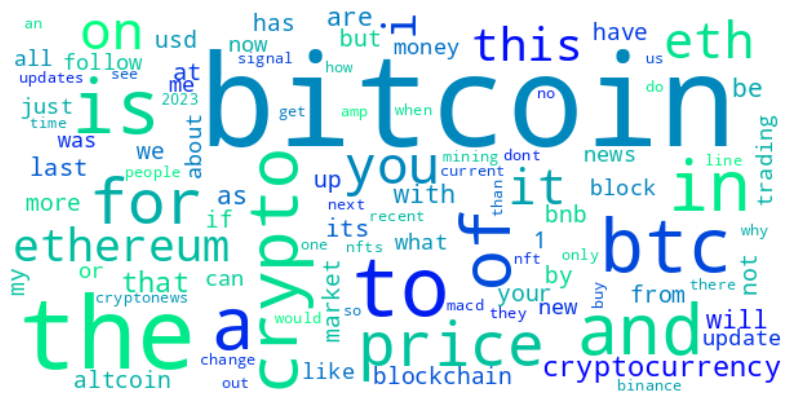

In [ ]:
Wordcloud(wd)

## **APPLY FUNCTIONS**

In [ ]:
print('DF shape all\'inizio:', df.shape)
df['Tweet'] = df['Tweet'].apply(CleanTweets)
df = RemoveTweetsWithMoreThanKWords(df,3)
df = df.reset_index(drop=True)
print('DF shape dopo RemoveTweetsWithMoreThanKWords:', df.shape)
df = RemoveTweetWithToken(df, 'Tweet', 'address')
df = RemoveTweetWithToken(df, 'Tweet', 'airdrop')
df = RemoveTweetWithToken(df, 'Tweet', 'giveaway')
df = RemoveTweetWithToken(df, 'Tweet', 'price update')
df = RemoveTweetWithToken(df, 'Tweet', 'price updates')
df = RemoveTweetWithToken(df, 'Tweet', '$ update')
df = RemoveTweetWithToken(df, 'Tweet', 'update $')
df = RemoveTweetWithToken(df, 'Tweet', 'prices update')
print('DF shape dopo RemoveTweetWithToken:', df.shape)
df = RemoveAMP(df)
print('DF shape dopo RemoveAMP:', df.shape)
df = GetTweetWith2Tokens(df, 'Tweet', 'bitcoin', 'btc') #at least 1 of these 2 tokens
print('DF shape dopo GetTweetWith2Tokens:', df.shape)
df = RemoveTweetWith2TokenS(df, 'Tweet', 'close', 'low')
df = RemoveTweetWith2TokenS(df, 'Tweet', 'close', 'high')
print('DF shape dopo RemoveTweetWith2TokenS:', df.shape)
df = df.reset_index(drop=True)
df = RemoveTweetsWithLongWords(df, 15)
print('DF shape dopo RemoveTweetsWithLongWords:', df.shape)
df = df.reset_index(drop=True)
#df['Tweet'] = df['Tweet'].apply(RemovePunctuation)
df = RemoveStopwords(df)

df = df.reset_index(drop=True)

print('DF shape alla fine:', df.shape)

DF shape all'inizio: (1080252, 9)
DF shape dopo RemoveTweetsWithMoreThanKWords: (1029195, 9)
DF shape dopo RemoveTweetWithToken: (988332, 9)
DF shape dopo RemoveAMP: (988332, 9)
DF shape dopo GetTweetWith2Tokens: (932682, 9)
DF shape dopo RemoveTweetWith2TokenS: (932304, 9)


  0%|          | 0/932304 [00:00<?, ?it/s]

<ipython-input-2-840d0184b561>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['check_len'][i] = 0


Tweet rimossi per parole troppo lunghe: 97433
DF shape dopo RemoveTweetsWithLongWords: (848719, 9)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


DF shape alla fine: (848719, 9)


## Escludo gli user anomali

In [ ]:
user_exclude = df['Username'].value_counts().rename_axis('Username').reset_index(name='Tweet_count')
df = pd.merge(df, user_exclude, on='Username', how='inner')
df

,ID,Datetime,Username,Tweet,Likes,Retweets,Risposte,Citazioni,day,Tweet_count
0,1609338613539504128,2023-01-01 00:00:00,CryptingUp,bitcoin price decreased last hs #btc bitcoin,0,0,0,0,2023-01-01,763
1,1609353712903900928,2023-01-01 01:00:00,CryptingUp,bitcoin price decreased last hs #btc bitcoin,0,0,0,0,2023-01-01,763
2,1609368812398252032,2023-01-01 02:00:00,CryptingUp,bitcoin price decreased last hs #btc bitcoin,0,0,0,0,2023-01-01,763
3,1609383911964000000,2023-01-01 03:00:00,CryptingUp,bitcoin price decreased last hs #btc bitcoin,0,0,0,0,2023-01-01,763
4,1609399011408069120,2023-01-01 04:00:00,CryptingUp,bitcoin price decreased last hs #btc bitcoin,0,0,0,0,2023-01-01,763
...,...,...,...,...,...,...,...,...,...,...
848714,1620572013009182976,2023-01-31 23:57:31,crimvaldis,red pill makes go back time invest bitcoin ear...,0,0,0,0,2023-01-31,1
848715,1620572275845041920,2023-01-31 23:58:33,MadeInUSACrypto,bitcoin short term fate bitcoin markets determ...,3,4,15,0,2023-01-31,1
848716,1620572408540439040,2023-01-31 23:59:05,poseidon_pisces,discovered bitcoin enough,0,0,0,0,2023-01-31,1
848717,1620572424143094016,2023-01-31 23:59:09,Michael51261935,one block bitcoin block #btc #cryptocurrency,0,0,0,0,2023-01-31,1


195.0


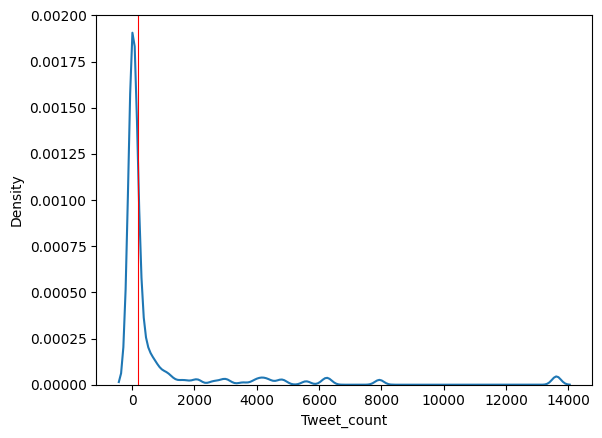

In [ ]:
soglia = 70
print(np.percentile(df['Tweet_count'], soglia))

sns.kdeplot(df['Tweet_count'])
plt.axvline(x=np.percentile(df['Tweet_count'], soglia), color='red', lw=0.8)

In [ ]:
df=df[df['Tweet_count']<np.percentile(df['Tweet_count'], soglia)]
df.sort_values(by='Datetime', inplace=True)
df = df.reset_index(drop=True)
df

<ipython-input-10-7c14e94b0f95>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='Datetime', inplace=True)


,ID,Datetime,Username,Tweet,Likes,Retweets,Risposte,Citazioni,day,Tweet_count
0,1609338615129148928,2023-01-01 00:00:00,CryptoNerdApp,current price bitcoin btc bitcoin #cryptocurre...,0,0,0,0,2023-01-01,124
1,1609338622615896064,2023-01-01 00:00:02,bitcoin_bunnies,bitcoin unconfiscatable store value provides c...,2,0,0,0,2023-01-01,83
2,1609338624096574976,2023-01-01 00:00:02,Bitfinexed,tether claims made million past year b reserve...,130,14,5,1,2023-01-01,50
3,1609338628051800064,2023-01-01 00:00:03,TomCrownCrypto,breaking bitcoin historyfirst yearly bearish e...,1865,216,264,21,2023-01-01,27
4,1609338631985963008,2023-01-01 00:00:04,OpticRedrum,happy new year k sats k #btc bitcoin #binance ...,34,2,8,0,2023-01-01,3
...,...,...,...,...,...,...,...,...,...,...
593630,1620572527092432896,2023-01-31 23:59:33,LauraWaIker,tesla records bitcoin net loss,3,0,0,0,2023-01-31,3
593631,1620572552291844096,2023-01-31 23:59:39,0xGrug,hack bitcoin timeline best timeline,1,0,2,1,2023-01-31,4
593632,1620572608231256064,2023-01-31 23:59:53,knowbitcoin,hopefully someone would buy bitcoin hats,1,0,0,0,2023-01-31,29
593633,1620572614975525120,2023-01-31 23:59:54,NancyLWiIson,understand political ramifications bitcoin thi...,0,0,0,0,2023-01-31,3


## Word Cloud

In [ ]:
wd = WordCount(df['Tweet'])
wd.head(30)

,Word,Frequency
0,bitcoin,664769
1,btc,103655
2,crypto,94889
3,k,45233
4,price,39826
5,like,34902
6,market,33509
7,money,32204
8,cryptocurrency,31818
9,ethereum,29252


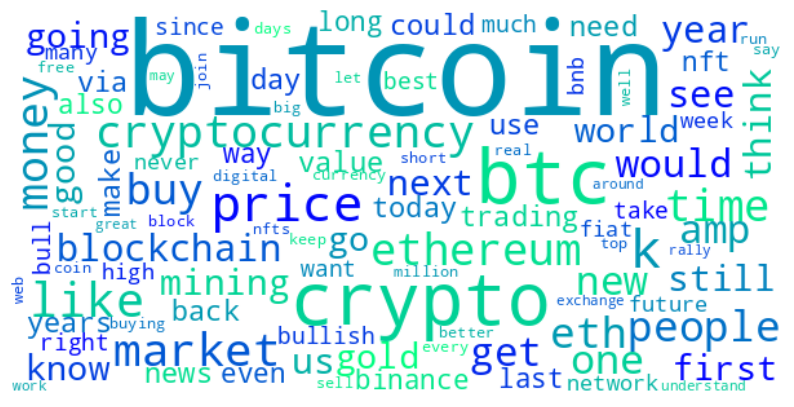

In [ ]:
Wordcloud(wd)

In [ ]:
df

,ID,Datetime,Username,Tweet,Likes,Retweets,Risposte,Citazioni,day,Tweet_count
0,1609338615129148928,2023-01-01 00:00:00,CryptoNerdApp,current price bitcoin btc bitcoin #cryptocurre...,0,0,0,0,2023-01-01,124
1,1609338622615896064,2023-01-01 00:00:02,bitcoin_bunnies,bitcoin unconfiscatable store value provides c...,2,0,0,0,2023-01-01,83
2,1609338624096574976,2023-01-01 00:00:02,Bitfinexed,tether claims made million past year b reserve...,130,14,5,1,2023-01-01,50
3,1609338628051800064,2023-01-01 00:00:03,TomCrownCrypto,breaking bitcoin historyfirst yearly bearish e...,1865,216,264,21,2023-01-01,27
4,1609338631985963008,2023-01-01 00:00:04,OpticRedrum,happy new year k sats k #btc bitcoin #binance ...,34,2,8,0,2023-01-01,3
...,...,...,...,...,...,...,...,...,...,...
593630,1620572527092432896,2023-01-31 23:59:33,LauraWaIker,tesla records bitcoin net loss,3,0,0,0,2023-01-31,3
593631,1620572552291844096,2023-01-31 23:59:39,0xGrug,hack bitcoin timeline best timeline,1,0,2,1,2023-01-31,4
593632,1620572608231256064,2023-01-31 23:59:53,knowbitcoin,hopefully someone would buy bitcoin hats,1,0,0,0,2023-01-31,29
593633,1620572614975525120,2023-01-31 23:59:54,NancyLWiIson,understand political ramifications bitcoin thi...,0,0,0,0,2023-01-31,3


# **TEXTBLOB**

In TextBlob, the polarity score of a text is calculated by taking the average of the polarity scores of individual sentences in the text. The polarity score of each sentence is obtained by summing up the polarity scores of individual words in the sentence and normalizing the sum by the number of words in the sentence.

The polarity score of each word is obtained by looking up the word in the TextBlob lexicon, which contains a list of words with corresponding polarity scores ranging from -1 (most negative) to +1 (most positive). The lexicon is based on the WordNet database and includes a set of hand-crafted rules for handling negation, intensifiers, and other linguistic features.

TextBlob also provides a subjectivity score for each sentence, which represents the degree to which the sentence expresses a subjective opinion rather than a factual statement. The subjectivity score of a text is calculated by taking the average of the subjectivity scores of individual sentences in the text. The subjectivity score of each sentence is obtained by summing up the subjectivity scores of individual words in the sentence and normalizing the sum by the number of words in the sentence.

The subjectivity score of each word is obtained by looking up the word in the TextBlob lexicon, which contains a list of words with corresponding subjectivity scores ranging from 0 (completely objective) to 1 (completely subjective).

Overall, TextBlob's sentiment analysis is a simple and easy-to-use approach that can provide decent results for many use cases. However, it may not perform as well as more sophisticated approaches that take into account the context, syntax, and semantics of the text.

In [ ]:
df['T_Subjectivity'] =  df['Tweet'].apply(getSubjectivity)
df['T_Polarity'] = df['Tweet'].apply(getPolarity)
df['T_Sentiment'] = df['T_Polarity'].apply(getSentiment)
df

,ID,Datetime,Username,Tweet,Likes,Retweets,Risposte,Citazioni,day,Tweet_count,T_Subjectivity,T_Polarity,T_Sentiment
0,1609338615129148928,2023-01-01 00:00:00,CryptoNerdApp,current price bitcoin btc bitcoin #cryptocurre...,0,0,0,0,2023-01-01,124,0.400000,0.000000,NEUTRAL
1,1609338622615896064,2023-01-01 00:00:02,bitcoin_bunnies,bitcoin unconfiscatable store value provides c...,2,0,0,0,2023-01-01,83,0.000000,0.000000,NEUTRAL
2,1609338624096574976,2023-01-01 00:00:02,Bitfinexed,tether claims made million past year b reserve...,130,14,5,1,2023-01-01,50,0.158333,-0.208333,NEGATIVE
3,1609338628051800064,2023-01-01 00:00:03,TomCrownCrypto,breaking bitcoin historyfirst yearly bearish e...,1865,216,264,21,2023-01-01,27,0.000000,0.000000,NEUTRAL
4,1609338631985963008,2023-01-01 00:00:04,OpticRedrum,happy new year k sats k #btc bitcoin #binance ...,34,2,8,0,2023-01-01,3,0.727273,0.468182,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
593630,1620572527092432896,2023-01-31 23:59:33,LauraWaIker,tesla records bitcoin net loss,3,0,0,0,2023-01-31,3,0.000000,0.000000,NEUTRAL
593631,1620572552291844096,2023-01-31 23:59:39,0xGrug,hack bitcoin timeline best timeline,1,0,2,1,2023-01-31,4,0.300000,1.000000,POSITIVE
593632,1620572608231256064,2023-01-31 23:59:53,knowbitcoin,hopefully someone would buy bitcoin hats,1,0,0,0,2023-01-31,29,0.000000,0.000000,NEUTRAL
593633,1620572614975525120,2023-01-31 23:59:54,NancyLWiIson,understand political ramifications bitcoin thi...,0,0,0,0,2023-01-31,3,0.150000,0.100000,NEUTRAL


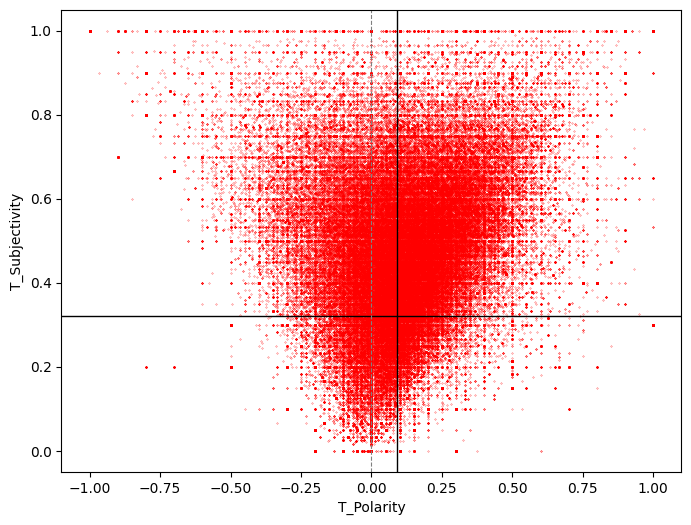

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df['T_Polarity'], df['T_Subjectivity'], color='red',s=0.05)
plt.xlabel('T_Polarity')
plt.ylabel('T_Subjectivity')
plt.axhline(y=df['T_Subjectivity'].mean(), color='k', lw=1)
plt.axvline(x=df['T_Polarity'].mean(), color='k', lw=1)
plt.axvline(x=0, color='grey', lw=0.8, ls='--')
plt.show()

In [ ]:
positivi,neutrali,negativi  = len(df[df['T_Sentiment']=='POSITIVE']),len(df[df['T_Sentiment']=='NEUTRAL']),len(df[df['T_Sentiment']=='NEGATIVE'])
qpositivi,qneutrali,qnegativi = 100*round(positivi/(negativi+positivi+neutrali),2),100*round(neutrali/(negativi+positivi+neutrali),2),100*round(negativi/(negativi+positivi+neutrali),2)
print(f'Positivi:{positivi},{qpositivi}%')
print(f'Neutrali:{neutrali},{qneutrali}%')
print(f'Negativi:{negativi},{qnegativi}%')

Positivi:204043,34.0%
Neutrali:333578,56.00000000000001%
Negativi:56014,9.0%


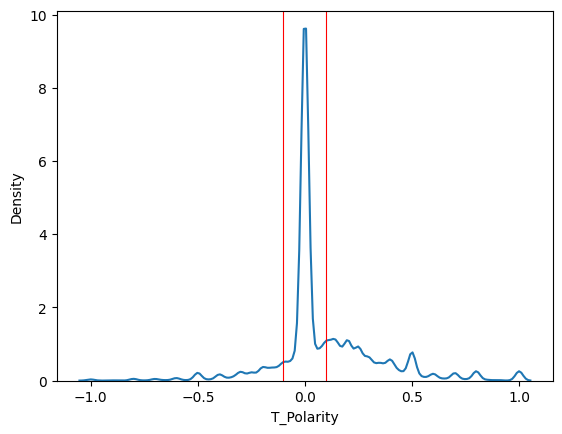

In [ ]:
taglio = 0.1
sns.kdeplot(df['T_Polarity'])
plt.axvline(x=-1*taglio, color='red', lw=0.8)
plt.axvline(x=taglio, color='red', lw=0.8)

FILTRO IL DF

<Axes: xlabel='T_Polarity', ylabel='Density'>

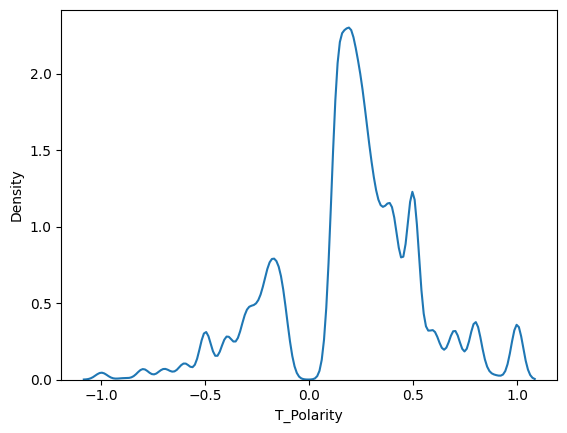

In [ ]:
df = df[(df['T_Sentiment']=='POSITIVE') | (df['T_Sentiment']=='NEGATIVE')] #REMOVE NEUTRAL
sns.kdeplot(df['T_Polarity'])

<Axes: xlabel='T_Polarity', ylabel='Density'>

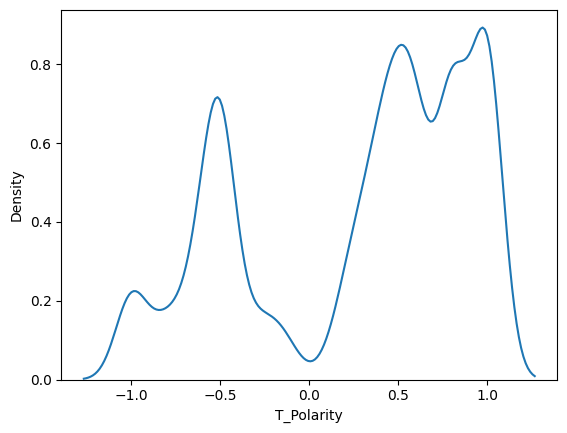

In [ ]:
df = df[df['T_Subjectivity']>0.9]
sns.kdeplot(df['T_Polarity'])

In [ ]:
df

,ID,Datetime,Username,Tweet,Likes,Retweets,Risposte,Citazioni,day,Tweet_count,T_Subjectivity,T_Polarity,T_Sentiment
19,1609338744087233024,2023-01-01 00:00:31,slavikcrypto,russia head congress finance committee impossi...,20,5,8,0,2023-01-01,194,1.000000,-0.666667,NEGATIVE
129,1609341058764135936,2023-01-01 00:09:43,daanksy,think hilarious yoinking bitcoin magazine twee...,4,0,1,0,2023-01-01,3,1.000000,0.500000,POSITIVE
161,1609341606074647040,2023-01-01 00:11:53,TheMillionStats,december million mm price ath risk potential d...,6,2,1,0,2023-01-01,28,0.916667,0.266667,POSITIVE
183,1609341985181078016,2023-01-01 00:13:24,rolandkovacs68,going excellent year bitcoin,0,0,0,0,2023-01-01,118,1.000000,1.000000,POSITIVE
189,1609342190903493120,2023-01-01 00:14:13,cassinzhje,magic internet money book bitcoin hkigmcy,0,0,0,0,2023-01-01,1,1.000000,0.500000,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
593331,1620567034902810880,2023-01-31 23:37:44,tab592255,happy th birthday bitcoin,0,0,0,0,2023-01-31,1,1.000000,0.800000,POSITIVE
593399,1620568297862225920,2023-01-31 23:42:45,emotions_bot,sad feeling wasting time beneath someone bitcoin,0,0,0,0,2023-01-31,102,1.000000,-0.500000,NEGATIVE
593444,1620569250695119104,2023-01-31 23:46:32,davidlhansen3,ah burger joint bank allow blockchain deposits...,0,0,0,0,2023-01-31,7,1.000000,-0.250000,NEGATIVE
593562,1620571387466505984,2023-01-31 23:55:02,neiledmu,finally bitcoin becoming stable,2,0,1,0,2023-01-31,20,0.925000,0.225000,POSITIVE


# **VADER**

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically designed for social media texts. It is built upon a human-curated list of words with corresponding sentiment scores and a set of syntactical and grammatical rules that govern how these scores are combined and adjusted.

In VADER, the polarity score of a text is calculated by summing the sentiment scores of individual words in the text and normalizing the sum by the length of the text. The sentiment score of each word is obtained by looking up the word in the VADER lexicon, which contains a list of over 7,500 words and emoticons with scores ranging from -4 (most negative) to +4 (most positive).

The VADER lexicon also contains a set of rules for adjusting the sentiment scores of words based on their context, such as negation, intensifiers, and capitalization. These rules help VADER to handle the nuances and complexities of social media language, which often contains non-standard grammar, sarcasm, irony, and other forms of ambiguity.

By summing up the adjusted sentiment scores of all the words in a text and normalizing the result by the text's length, VADER produces a final polarity score between -1 (most negative) and +1 (most positive), with values around zero indicating neutral sentiment.

In [ ]:
analyzer = SentimentIntensityAnalyzer()
df['V_Polarity'] = df['Tweet'].apply(lambda tweet: analyzer.polarity_scores(tweet)['compound'])
df['V_Sentiment'] = df['V_Polarity'].apply(getSentiment)
df

,ID,Datetime,Username,Tweet,Likes,Retweets,Risposte,Citazioni,day,Tweet_count,T_Subjectivity,T_Polarity,T_Sentiment,V_Polarity,V_Sentiment
19,1609338744087233024,2023-01-01 00:00:31,slavikcrypto,russia head congress finance committee impossi...,20,5,8,0,2023-01-01,194,1.000000,-0.666667,NEGATIVE,0.0000,NEUTRAL
129,1609341058764135936,2023-01-01 00:09:43,daanksy,think hilarious yoinking bitcoin magazine twee...,4,0,1,0,2023-01-01,3,1.000000,0.500000,POSITIVE,0.4019,POSITIVE
161,1609341606074647040,2023-01-01 00:11:53,TheMillionStats,december million mm price ath risk potential d...,6,2,1,0,2023-01-01,28,0.916667,0.266667,POSITIVE,0.7003,POSITIVE
183,1609341985181078016,2023-01-01 00:13:24,rolandkovacs68,going excellent year bitcoin,0,0,0,0,2023-01-01,118,1.000000,1.000000,POSITIVE,0.5719,POSITIVE
189,1609342190903493120,2023-01-01 00:14:13,cassinzhje,magic internet money book bitcoin hkigmcy,0,0,0,0,2023-01-01,1,1.000000,0.500000,POSITIVE,0.0000,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593331,1620567034902810880,2023-01-31 23:37:44,tab592255,happy th birthday bitcoin,0,0,0,0,2023-01-31,1,1.000000,0.800000,POSITIVE,0.5719,POSITIVE
593399,1620568297862225920,2023-01-31 23:42:45,emotions_bot,sad feeling wasting time beneath someone bitcoin,0,0,0,0,2023-01-31,102,1.000000,-0.500000,NEGATIVE,-0.6486,NEGATIVE
593444,1620569250695119104,2023-01-31 23:46:32,davidlhansen3,ah burger joint bank allow blockchain deposits...,0,0,0,0,2023-01-31,7,1.000000,-0.250000,NEGATIVE,0.4404,POSITIVE
593562,1620571387466505984,2023-01-31 23:55:02,neiledmu,finally bitcoin becoming stable,2,0,1,0,2023-01-31,20,0.925000,0.225000,POSITIVE,0.2960,POSITIVE


In [ ]:
positivi,neutrali,negativi  = len(df[df['V_Sentiment']=='POSITIVE']),len(df[df['V_Sentiment']=='NEUTRAL']),len(df[df['V_Sentiment']=='NEGATIVE'])
qpositivi,qneutrali,qnegativi = 100*round(positivi/(negativi+positivi+neutrali),2),100*round(neutrali/(negativi+positivi+neutrali),2),100*round(negativi/(negativi+positivi+neutrali),2)
print(f'Positivi:{positivi},{qpositivi}%')
print(f'Neutrali:{neutrali},{qneutrali}%')
print(f'Negativi:{negativi},{qnegativi}%')

Positivi:12046,65.0%
Neutrali:2157,12.0%
Negativi:4397,24.0%


FILTRO IL DF

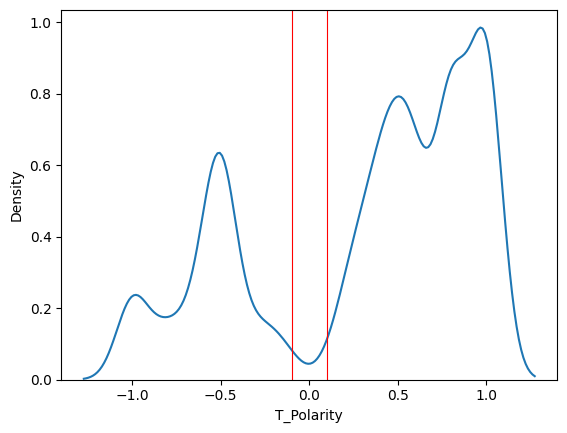

In [ ]:
df = df[(df['V_Sentiment']=='POSITIVE') | (df['V_Sentiment']=='NEGATIVE')] #REMOVE NEUTRAL
sns.kdeplot(df['T_Polarity'])
plt.axvline(x=-1*taglio, color='red', lw=0.8)
plt.axvline(x=taglio, color='red', lw=0.8)

In [ ]:
df = df.reset_index(drop=True)
df

,ID,Datetime,Username,Tweet,Likes,Retweets,Risposte,Citazioni,day,Tweet_count,T_Subjectivity,T_Polarity,T_Sentiment,V_Polarity,V_Sentiment
0,1609341058764135936,2023-01-01 00:09:43,daanksy,think hilarious yoinking bitcoin magazine twee...,4,0,1,0,2023-01-01,3,1.000000,0.500000,POSITIVE,0.4019,POSITIVE
1,1609341606074647040,2023-01-01 00:11:53,TheMillionStats,december million mm price ath risk potential d...,6,2,1,0,2023-01-01,28,0.916667,0.266667,POSITIVE,0.7003,POSITIVE
2,1609341985181078016,2023-01-01 00:13:24,rolandkovacs68,going excellent year bitcoin,0,0,0,0,2023-01-01,118,1.000000,1.000000,POSITIVE,0.5719,POSITIVE
3,1609342466338980096,2023-01-01 00:15:18,DJJoeSauce,kapnspaulding found bitcoin user vault locatio...,2,0,0,0,2023-01-01,11,1.000000,1.000000,POSITIVE,0.7964,POSITIVE
4,1609343091659375104,2023-01-01 00:17:47,guysnovelutumba,prepare watch ball drop perfect time renew loy...,0,0,0,0,2023-01-01,9,1.000000,1.000000,POSITIVE,0.7269,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16438,1620567034902810880,2023-01-31 23:37:44,tab592255,happy th birthday bitcoin,0,0,0,0,2023-01-31,1,1.000000,0.800000,POSITIVE,0.5719,POSITIVE
16439,1620568297862225920,2023-01-31 23:42:45,emotions_bot,sad feeling wasting time beneath someone bitcoin,0,0,0,0,2023-01-31,102,1.000000,-0.500000,NEGATIVE,-0.6486,NEGATIVE
16440,1620569250695119104,2023-01-31 23:46:32,davidlhansen3,ah burger joint bank allow blockchain deposits...,0,0,0,0,2023-01-31,7,1.000000,-0.250000,NEGATIVE,0.4404,POSITIVE
16441,1620571387466505984,2023-01-31 23:55:02,neiledmu,finally bitcoin becoming stable,2,0,1,0,2023-01-31,20,0.925000,0.225000,POSITIVE,0.2960,POSITIVE


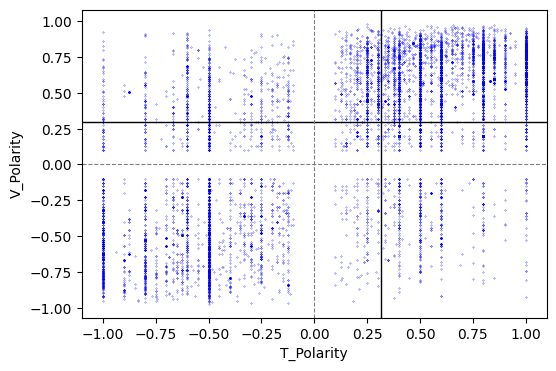

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(df['T_Polarity'], df['V_Polarity'], color='blue',s=0.05)
plt.xlabel('T_Polarity')
plt.ylabel('V_Polarity')
plt.axhline(y=df['V_Polarity'].mean(), color='k', lw=1)
plt.axvline(x=df['T_Polarity'].mean(), color='k', lw=1)
plt.axvline(x=0, color='grey', lw=0.8, ls='--')
plt.axhline(y=0, color='grey', lw=0.8, ls='--')
plt.show()

In [ ]:
wd = WordCount(df['Tweet'])
wd.head(30)

,Word,Frequency
0,bitcoin,17929
1,cryptocurrency,2531
2,awesome,2318
3,happy,2205
4,join,2165
5,found,2077
6,playing,2057
7,user,2042
8,coinhuntworld,2036
9,vault,2035


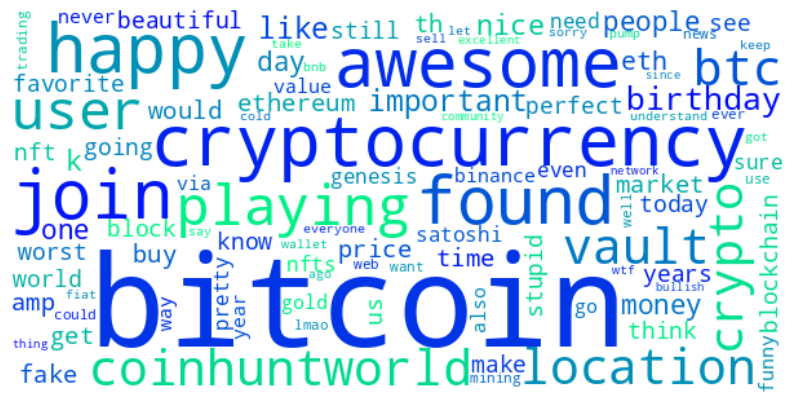

In [ ]:
Wordcloud(wd)

In [ ]:
df = df[df['V_Sentiment']==df['T_Sentiment']]
df = df.reset_index(drop=True)
df

,ID,Datetime,Username,Tweet,Likes,Retweets,Risposte,Citazioni,day,Tweet_count,T_Subjectivity,T_Polarity,T_Sentiment,V_Polarity,V_Sentiment
0,1609341058764135936,2023-01-01 00:09:43,daanksy,think hilarious yoinking bitcoin magazine twee...,4,0,1,0,2023-01-01,3,1.000000,0.500000,POSITIVE,0.4019,POSITIVE
1,1609341606074647040,2023-01-01 00:11:53,TheMillionStats,december million mm price ath risk potential d...,6,2,1,0,2023-01-01,28,0.916667,0.266667,POSITIVE,0.7003,POSITIVE
2,1609341985181078016,2023-01-01 00:13:24,rolandkovacs68,going excellent year bitcoin,0,0,0,0,2023-01-01,118,1.000000,1.000000,POSITIVE,0.5719,POSITIVE
3,1609342466338980096,2023-01-01 00:15:18,DJJoeSauce,kapnspaulding found bitcoin user vault locatio...,2,0,0,0,2023-01-01,11,1.000000,1.000000,POSITIVE,0.7964,POSITIVE
4,1609343091659375104,2023-01-01 00:17:47,guysnovelutumba,prepare watch ball drop perfect time renew loy...,0,0,0,0,2023-01-01,9,1.000000,1.000000,POSITIVE,0.7269,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14818,1620565981067354112,2023-01-31 23:33:33,ChainlinkPuppet,another sexy h candle bitcoin,1,0,0,0,2023-01-31,6,1.000000,0.500000,POSITIVE,0.5267,POSITIVE
14819,1620566927780486912,2023-01-31 23:37:18,JacquieOtt7,hmm seem picked bots fakes bitcoin stupid,1,0,0,0,2023-01-31,2,1.000000,-0.800000,NEGATIVE,-0.7351,NEGATIVE
14820,1620567034902810880,2023-01-31 23:37:44,tab592255,happy th birthday bitcoin,0,0,0,0,2023-01-31,1,1.000000,0.800000,POSITIVE,0.5719,POSITIVE
14821,1620568297862225920,2023-01-31 23:42:45,emotions_bot,sad feeling wasting time beneath someone bitcoin,0,0,0,0,2023-01-31,102,1.000000,-0.500000,NEGATIVE,-0.6486,NEGATIVE


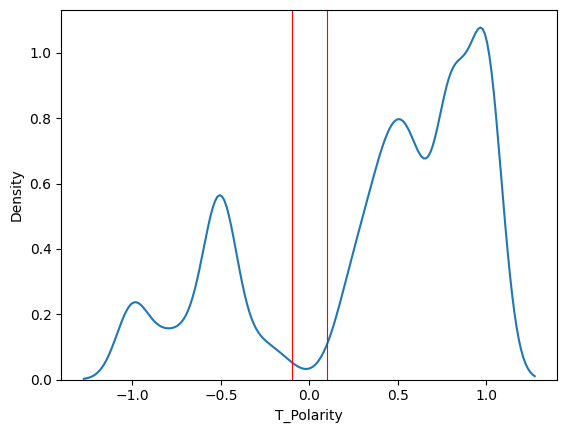

In [ ]:
sns.kdeplot(df['T_Polarity'])
plt.axvline(x=-1*taglio, color='red', lw=0.8)
plt.axvline(x=taglio, color='red', lw=0.8)

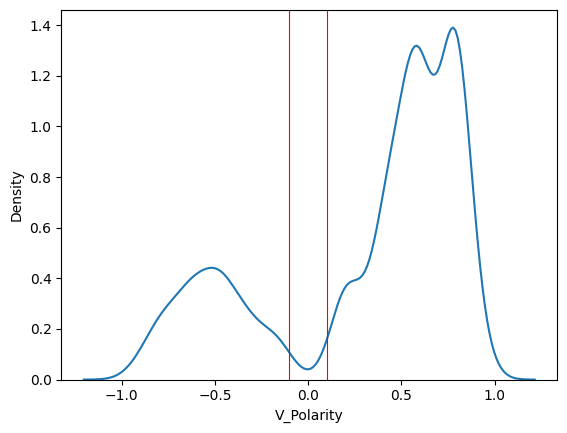

In [ ]:
sns.kdeplot(df['V_Polarity'])
plt.axvline(x=-1*taglio, color='red', lw=0.8)
plt.axvline(x=taglio, color='red', lw=0.8)

In [ ]:
wd = WordCount(df['Tweet'])
wd.head(30)

,Word,Frequency
0,bitcoin,16078
1,cryptocurrency,2474
2,awesome,2316
3,happy,2164
4,join,2155
5,found,2072
6,playing,2053
7,user,2040
8,coinhuntworld,2036
9,vault,2034


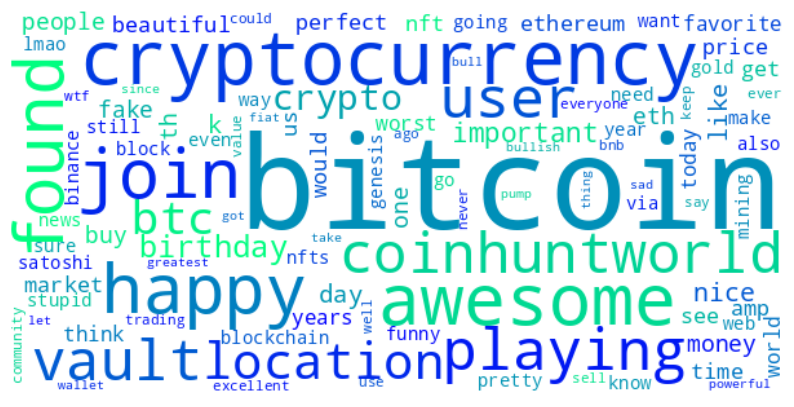

In [ ]:
Wordcloud(wd)

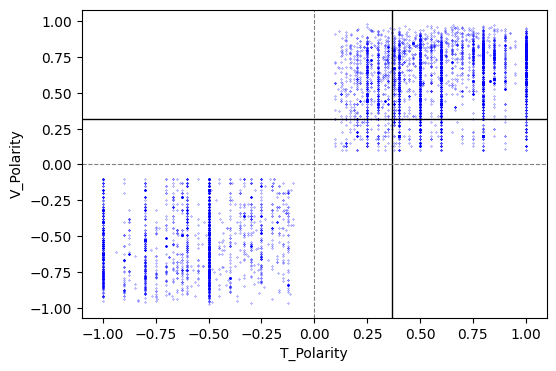

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(df['T_Polarity'], df['V_Polarity'], color='blue',s=0.05)
plt.xlabel('T_Polarity')
plt.ylabel('V_Polarity')
plt.axhline(y=df['V_Polarity'].mean(), color='k', lw=1)
plt.axvline(x=df['T_Polarity'].mean(), color='k', lw=1)
plt.axvline(x=0, color='grey', lw=0.8, ls='--')
plt.axhline(y=0, color='grey', lw=0.8, ls='--')
plt.show()

In [ ]:
df

,ID,Datetime,Username,Tweet,Likes,Retweets,Risposte,Citazioni,day,Tweet_count,T_Subjectivity,T_Polarity,T_Sentiment,V_Polarity,V_Sentiment
0,1609341058764135936,2023-01-01 00:09:43,daanksy,think hilarious yoinking bitcoin magazine twee...,4,0,1,0,2023-01-01,3,1.000000,0.500000,POSITIVE,0.4019,POSITIVE
1,1609341606074647040,2023-01-01 00:11:53,TheMillionStats,december million mm price ath risk potential d...,6,2,1,0,2023-01-01,28,0.916667,0.266667,POSITIVE,0.7003,POSITIVE
2,1609341985181078016,2023-01-01 00:13:24,rolandkovacs68,going excellent year bitcoin,0,0,0,0,2023-01-01,118,1.000000,1.000000,POSITIVE,0.5719,POSITIVE
3,1609342466338980096,2023-01-01 00:15:18,DJJoeSauce,kapnspaulding found bitcoin user vault locatio...,2,0,0,0,2023-01-01,11,1.000000,1.000000,POSITIVE,0.7964,POSITIVE
4,1609343091659375104,2023-01-01 00:17:47,guysnovelutumba,prepare watch ball drop perfect time renew loy...,0,0,0,0,2023-01-01,9,1.000000,1.000000,POSITIVE,0.7269,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14818,1620565981067354112,2023-01-31 23:33:33,ChainlinkPuppet,another sexy h candle bitcoin,1,0,0,0,2023-01-31,6,1.000000,0.500000,POSITIVE,0.5267,POSITIVE
14819,1620566927780486912,2023-01-31 23:37:18,JacquieOtt7,hmm seem picked bots fakes bitcoin stupid,1,0,0,0,2023-01-31,2,1.000000,-0.800000,NEGATIVE,-0.7351,NEGATIVE
14820,1620567034902810880,2023-01-31 23:37:44,tab592255,happy th birthday bitcoin,0,0,0,0,2023-01-31,1,1.000000,0.800000,POSITIVE,0.5719,POSITIVE
14821,1620568297862225920,2023-01-31 23:42:45,emotions_bot,sad feeling wasting time beneath someone bitcoin,0,0,0,0,2023-01-31,102,1.000000,-0.500000,NEGATIVE,-0.6486,NEGATIVE


# **FLAIR**

Flair is a Python library for natural language processing that includes a sentiment analysis module. Unlike TextBlob and VADER, Flair's sentiment analysis is based on machine learning and does not rely on lexicons or rule-based approaches.

Flair's sentiment analysis module is implemented as a deep learning model that is trained on a large corpus of annotated data. The model uses a combination of bidirectional LSTM and conditional random fields (CRF) to capture the contextual information and dependencies between words in a text.

To use Flair's sentiment analysis module, you first need to create a SentimentAnalyzer object and load a pre-trained sentiment analysis model. You can then pass the text to the analyze() method of the SentimentAnalyzer object to obtain the sentiment score of the text.

The sentiment score produced by Flair is a float value between 0 and 1, where 0 represents the most negative sentiment and 1 represents the most positive sentiment. Flair's sentiment analysis module can also produce a list of sentiment scores for each sentence in the text, which can be useful for analyzing the sentiment at a more fine-grained level.

Overall, Flair's sentiment analysis module is a powerful and flexible approach that can provide high-quality results for a wide range of use cases. However, it requires a large amount of annotated data and may be more complex and computationally expensive than simpler lexicon-based approaches like TextBlob and VADER.

Bidirectional LSTM (Long Short-Term Memory) and Conditional Random Fields (CRF) are two powerful deep learning techniques that are commonly used for natural language processing tasks such as sentiment analysis.

Bidirectional LSTM is a type of recurrent neural network (RNN) that is capable of processing sequential data such as text. Unlike traditional RNNs, which can only process the input sequence in one direction (i.e., from left to right or right to left), bidirectional LSTMs can process the input sequence in both directions simultaneously. This allows the model to capture both the past and future context of each word in the input sequence, which can be important for understanding the meaning of the text.

Conditional Random Fields, on the other hand, are a type of graphical model that can capture the dependencies between labels in a sequence. In the case of sentiment analysis, the labels represent the sentiment of each word in the input sequence (e.g., positive, negative, neutral). By modeling the dependencies between adjacent labels, CRFs can improve the accuracy of the sentiment analysis by enforcing constraints on the possible label sequences.

In the case of Flair's sentiment analysis module, the bidirectional LSTM is used to encode the input text into a sequence of hidden states that capture the contextual information of each word. The CRF is then used to predict the sentiment label for each word based on the encoded hidden states and the dependencies between adjacent labels.

By combining these two techniques, Flair's sentiment analysis module can capture both the local and global dependencies between words in a text, which can lead to more accurate and robust sentiment analysis results.

In [ ]:
!pip install -q flair
from flair.models import TextClassifier
from flair.data import Sentence

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.1/373.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 44.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 44.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 10.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB

In [ ]:
classifier = TextClassifier.load('en-sentiment')

df['F_Confidence'] = df['Tweet'].apply(lambda s: Flair(s)[0])
df['F_Sentiment'] = df['Tweet'].apply(lambda s: Flair(s)[1])
df

2023-04-27 15:07:46,875 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpapk83_bs


100%|██████████| 253M/253M [00:22<00:00, 11.6MB/s]

2023-04-27 15:08:10,057 copying /tmp/tmpapk83_bs to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2023-04-27 15:08:11,748 removing temp file /tmp/tmpapk83_bs


,ID,Datetime,Username,Tweet,Likes,Retweets,Risposte,Citazioni,day,Tweet_count,T_Subjectivity,T_Polarity,T_Sentiment,V_Polarity,V_Sentiment,F_Confidence,F_Sentiment
0,1609341058764135936,2023-01-01 00:09:43,daanksy,think hilarious yoinking bitcoin magazine twee...,4,0,1,0,2023-01-01,3,1.000000,0.500000,POSITIVE,0.4019,POSITIVE,0.965851,POSITIVE
1,1609341606074647040,2023-01-01 00:11:53,TheMillionStats,december million mm price ath risk potential d...,6,2,1,0,2023-01-01,28,0.916667,0.266667,POSITIVE,0.7003,POSITIVE,0.987431,POSITIVE
2,1609341985181078016,2023-01-01 00:13:24,rolandkovacs68,going excellent year bitcoin,0,0,0,0,2023-01-01,118,1.000000,1.000000,POSITIVE,0.5719,POSITIVE,0.973990,POSITIVE
3,1609342466338980096,2023-01-01 00:15:18,DJJoeSauce,kapnspaulding found bitcoin user vault locatio...,2,0,0,0,2023-01-01,11,1.000000,1.000000,POSITIVE,0.7964,POSITIVE,0.874579,POSITIVE
4,1609343091659375104,2023-01-01 00:17:47,guysnovelutumba,prepare watch ball drop perfect time renew loy...,0,0,0,0,2023-01-01,9,1.000000,1.000000,POSITIVE,0.7269,POSITIVE,0.988393,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14818,1620565981067354112,2023-01-31 23:33:33,ChainlinkPuppet,another sexy h candle bitcoin,1,0,0,0,2023-01-31,6,1.000000,0.500000,POSITIVE,0.5267,POSITIVE,0.999801,POSITIVE
14819,1620566927780486912,2023-01-31 23:37:18,JacquieOtt7,hmm seem picked bots fakes bitcoin stupid,1,0,0,0,2023-01-31,2,1.000000,-0.800000,NEGATIVE,-0.7351,NEGATIVE,0.999518,NEGATIVE
14820,1620567034902810880,2023-01-31 23:37:44,tab592255,happy th birthday bitcoin,0,0,0,0,2023-01-31,1,1.000000,0.800000,POSITIVE,0.5719,POSITIVE,0.992584,POSITIVE
14821,1620568297862225920,2023-01-31 23:42:45,emotions_bot,sad feeling wasting time beneath someone bitcoin,0,0,0,0,2023-01-31,102,1.000000,-0.500000,NEGATIVE,-0.6486,NEGATIVE,0.999063,NEGATIVE


<Axes: xlabel='F_Confidence', ylabel='Density'>

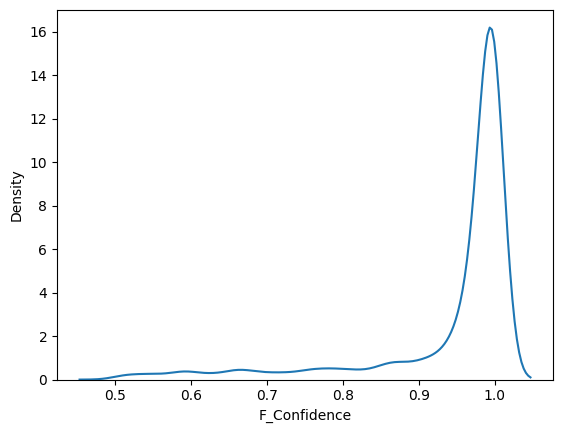

In [ ]:
sns.kdeplot(df['F_Confidence'])

In [ ]:
positivi,negativi  = len(df[df['F_Sentiment']=='POSITIVE']),len(df[df['F_Sentiment']=='NEGATIVE'])
qpositivi,qnegativi = 100*round(positivi/(negativi+positivi),2),100*round(negativi/(negativi+positivi),2)
print(f'Positivi:{positivi},{qpositivi}%')
print(f'Negativi:{negativi},{qnegativi}%')

Positivi:8801,59.0%
Negativi:6022,41.0%


In [ ]:
df = df[(df['V_Sentiment']==df['T_Sentiment']) & (df['V_Sentiment']==df['F_Sentiment'])]
df = df.reset_index(drop=True)
df

,ID,Datetime,Username,Tweet,Likes,Retweets,Risposte,Citazioni,day,Tweet_count,T_Subjectivity,T_Polarity,T_Sentiment,V_Polarity,V_Sentiment,F_Confidence,F_Sentiment
0,1609341058764135936,2023-01-01 00:09:43,daanksy,think hilarious yoinking bitcoin magazine twee...,4,0,1,0,2023-01-01,3,1.000000,0.500000,POSITIVE,0.4019,POSITIVE,0.965851,POSITIVE
1,1609341606074647040,2023-01-01 00:11:53,TheMillionStats,december million mm price ath risk potential d...,6,2,1,0,2023-01-01,28,0.916667,0.266667,POSITIVE,0.7003,POSITIVE,0.987431,POSITIVE
2,1609341985181078016,2023-01-01 00:13:24,rolandkovacs68,going excellent year bitcoin,0,0,0,0,2023-01-01,118,1.000000,1.000000,POSITIVE,0.5719,POSITIVE,0.973990,POSITIVE
3,1609342466338980096,2023-01-01 00:15:18,DJJoeSauce,kapnspaulding found bitcoin user vault locatio...,2,0,0,0,2023-01-01,11,1.000000,1.000000,POSITIVE,0.7964,POSITIVE,0.874579,POSITIVE
4,1609343091659375104,2023-01-01 00:17:47,guysnovelutumba,prepare watch ball drop perfect time renew loy...,0,0,0,0,2023-01-01,9,1.000000,1.000000,POSITIVE,0.7269,POSITIVE,0.988393,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12143,1620565981067354112,2023-01-31 23:33:33,ChainlinkPuppet,another sexy h candle bitcoin,1,0,0,0,2023-01-31,6,1.000000,0.500000,POSITIVE,0.5267,POSITIVE,0.999801,POSITIVE
12144,1620566927780486912,2023-01-31 23:37:18,JacquieOtt7,hmm seem picked bots fakes bitcoin stupid,1,0,0,0,2023-01-31,2,1.000000,-0.800000,NEGATIVE,-0.7351,NEGATIVE,0.999518,NEGATIVE
12145,1620567034902810880,2023-01-31 23:37:44,tab592255,happy th birthday bitcoin,0,0,0,0,2023-01-31,1,1.000000,0.800000,POSITIVE,0.5719,POSITIVE,0.992584,POSITIVE
12146,1620568297862225920,2023-01-31 23:42:45,emotions_bot,sad feeling wasting time beneath someone bitcoin,0,0,0,0,2023-01-31,102,1.000000,-0.500000,NEGATIVE,-0.6486,NEGATIVE,0.999063,NEGATIVE


In [ ]:
df = df[df['F_Confidence']>=0.9]
df

,ID,Datetime,Username,Tweet,Likes,Retweets,Risposte,Citazioni,day,Tweet_count,T_Subjectivity,T_Polarity,T_Sentiment,V_Polarity,V_Sentiment,F_Confidence,F_Sentiment
0,1609341058764135936,2023-01-01 00:09:43,daanksy,think hilarious yoinking bitcoin magazine twee...,4,0,1,0,2023-01-01,3,1.000000,0.500000,POSITIVE,0.4019,POSITIVE,0.965851,POSITIVE
1,1609341606074647040,2023-01-01 00:11:53,TheMillionStats,december million mm price ath risk potential d...,6,2,1,0,2023-01-01,28,0.916667,0.266667,POSITIVE,0.7003,POSITIVE,0.987431,POSITIVE
2,1609341985181078016,2023-01-01 00:13:24,rolandkovacs68,going excellent year bitcoin,0,0,0,0,2023-01-01,118,1.000000,1.000000,POSITIVE,0.5719,POSITIVE,0.973990,POSITIVE
4,1609343091659375104,2023-01-01 00:17:47,guysnovelutumba,prepare watch ball drop perfect time renew loy...,0,0,0,0,2023-01-01,9,1.000000,1.000000,POSITIVE,0.7269,POSITIVE,0.988393,POSITIVE
5,1609345007508495872,2023-01-01 00:25:24,darerealagile,stop insulting favourite color orange color bi...,0,0,0,0,2023-01-01,3,1.000000,-1.000000,NEGATIVE,-0.6597,NEGATIVE,0.985218,NEGATIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12143,1620565981067354112,2023-01-31 23:33:33,ChainlinkPuppet,another sexy h candle bitcoin,1,0,0,0,2023-01-31,6,1.000000,0.500000,POSITIVE,0.5267,POSITIVE,0.999801,POSITIVE
12144,1620566927780486912,2023-01-31 23:37:18,JacquieOtt7,hmm seem picked bots fakes bitcoin stupid,1,0,0,0,2023-01-31,2,1.000000,-0.800000,NEGATIVE,-0.7351,NEGATIVE,0.999518,NEGATIVE
12145,1620567034902810880,2023-01-31 23:37:44,tab592255,happy th birthday bitcoin,0,0,0,0,2023-01-31,1,1.000000,0.800000,POSITIVE,0.5719,POSITIVE,0.992584,POSITIVE
12146,1620568297862225920,2023-01-31 23:42:45,emotions_bot,sad feeling wasting time beneath someone bitcoin,0,0,0,0,2023-01-31,102,1.000000,-0.500000,NEGATIVE,-0.6486,NEGATIVE,0.999063,NEGATIVE


In [ ]:
wd = WordCount(df['Tweet'])
wd.head(30)

,Word,Frequency
0,bitcoin,11400
1,cryptocurrency,1942
2,awesome,1845
3,join,1701
4,happy,1668
5,found,1637
6,playing,1627
7,user,1619
8,vault,1618
9,location,1617


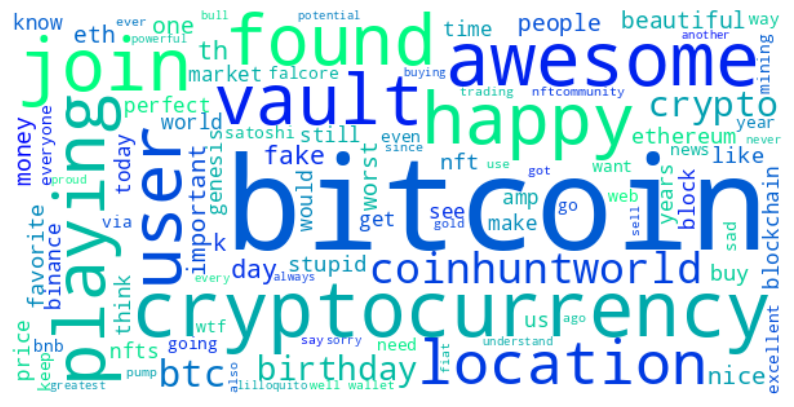

In [ ]:
Wordcloud(wd)

In [ ]:
df.to_parquet(f'{path}/BTC_2023_01_PROCESSED.parquet', compression='gzip')

# ANALISI E PLOT

In [ ]:
df = pd.read_parquet(f'{path}/BTC_2020_8to10_PROCESSED.parquet')

In [ ]:
hodl = 1 #quante candele tengo la posizione
soglia_ratio_Polarity = 10

mean = pd.pivot_table(df, values=['T_Polarity', 'V_Polarity'], index=['day'], aggfunc={'T_Polarity': 'mean', 'V_Polarity': 'mean'}).rename(columns={'T_Polarity': 'T_Polarity_mean','V_Polarity': 'V_Polarity_mean'})

df_pivot = btc.merge(mean, left_index=True, right_index=True)

df_pivot['ratio_T_Polarity'] = round(100*((df_pivot['T_Polarity_mean']/df_pivot['T_Polarity_mean'].shift(1))-1),2)
df_pivot['Return'] = round(100*((df_pivot['Close']/df_pivot['Open'])-1),2)
df_pivot['Entry'] = df_pivot['Open'].shift(-1)
df_pivot['Exit'] = df_pivot['Open'].shift(-1-hodl)
df_pivot['Gain_perc'] = round(100*(df_pivot['Exit']/df_pivot['Entry']-1),2)

df_pivot['Divergenza_Positiva'] = np.where(
    (df_pivot['ratio_T_Polarity']>soglia_ratio_Polarity) & 
    (df_pivot['Return']<0) & 
    (df_pivot['Return']>-1)
    ,"Buy","")
df_pivot['Divergenza_Negativa'] = np.where(
    (df_pivot['ratio_T_Polarity']<-soglia_ratio_Polarity) & 
    (df_pivot['Return']<1) &
    (df_pivot['Return']>0)
    ,"Sell","")
#df_pivot.to_excel("/content/drive/MyDrive/BTC/SENTIMETER/df_pivot_subj.xlsx")
df_pivot

,Open,Close,T_Polarity_mean,V_Polarity_mean,ratio_T_Polarity,Return,Entry,Exit,Gain_perc,Divergenza_Positiva,Divergenza_Negativa
2020-08-01,11322.570312,11759.592773,0.454775,0.355779,NaN,3.86,11758.764648,11043.768555,-6.08,,
2020-08-02,11758.764648,11053.614258,0.223031,0.166321,-50.96,-6.00,11043.768555,11246.203125,1.83,,
2020-08-03,11043.768555,11246.348633,0.122193,0.091267,-45.21,1.83,11246.203125,11203.823242,-0.38,,
2020-08-04,11246.203125,11205.892578,0.123770,0.097581,1.29,-0.36,11203.823242,11749.871094,4.87,,
2020-08-05,11203.823242,11747.022461,-0.025400,-0.083697,-120.52,4.85,11749.871094,11778.894531,0.25,,
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-27,13075.242188,13654.218750,0.222598,0.229760,-15.83,4.43,13654.214844,13271.298828,-2.80,,
2020-10-28,13654.214844,13271.285156,0.166136,0.167150,-25.37,-2.80,13271.298828,13437.874023,1.26,,
2020-10-29,13271.298828,13437.882812,0.198775,0.237038,19.65,1.26,13437.874023,13546.532227,0.81,,
2020-10-30,13437.874023,13546.522461,0.316587,0.303911,59.27,0.81,13546.532227,NaN,NaN,,


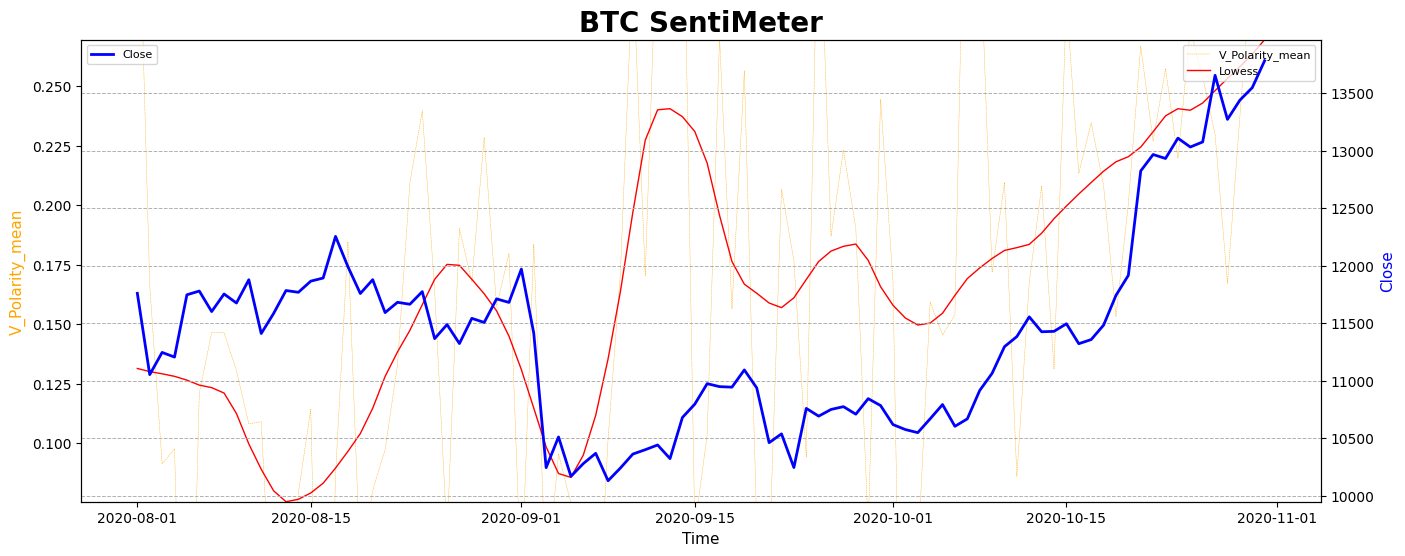

In [ ]:
VARIABILE = 'V_Polarity_mean'
VARIABILE_BTC = 'Close'
lowess = sm.nonparametric.lowess(df_pivot[VARIABILE], df_pivot.index, frac=0.15) #LOWESS

fig, ax1 = plt.subplots()
fig.set_size_inches(16, 6)
ax2 = ax1.twinx()

#Plot vertical lines
buy_dates = df_pivot.index[df_pivot['Divergenza_Positiva'] == 'Buy']
sell_dates = df_pivot.index[df_pivot['Divergenza_Negativa'] == 'Sell']
# plot vertical lines for each 'Buy' date
#for date in buy_dates:
  ##ax1.vlines(x=date, ymin=0, ymax=1, colors='green', linewidth=1)
#for date in sell_dates:
  #ax1.vlines(x=date, ymin=0, ymax=1, colors='red', linewidth=1)

ax1.plot(df_pivot.index, df_pivot[VARIABILE], color='orange', linewidth=0.3, ls='--', label = VARIABILE)
ax1.plot(df_pivot.index, lowess[:, 1], color='red', linewidth=1, label = 'Lowess')
ax2.plot(df_pivot.index, df_pivot[VARIABILE_BTC], color='blue', linewidth=2, label = VARIABILE_BTC)

ax1.set_xlabel('Time', size=11)
ax1.set_ylabel(VARIABILE, color='orange', size=11)
ax1.set_ylim(lowess[:, 1].min(),lowess[:, 1].max())
ax2.set_ylabel(VARIABILE_BTC, color='blue', size=11)
ax2.set_title('BTC SentiMeter', fontsize=20, fontweight="bold")
plt.grid(linewidth=0.7, linestyle='--')
ax1.legend(loc='upper right', prop={'size': 8})
ax2.legend(loc='upper left', prop={'size': 8})

#plt.savefig(f'{path}/BTC SentiMeter.jpg',bbox_inches='tight', dpi=600)
plt.show()

# Modifico Polarity

In [ ]:
df[df['Tweet'].str.contains("bearish", case=False)]

In [ ]:
df['Tweet'].str.contains("bullish").sum()

In [ ]:
df[df['Tweet'].str.contains("bullish", case=False)]

In [ ]:
df[df['Tweet'].str.contains("bearish", case=False)]

In [ ]:
# Apply the custom_polarity function to each tweet in the dataframe and store the results in a new column
df['Custom_Polarity'] = df['Tweet'].apply(custom_polarity)

In [ ]:
df[df['Tweet'].str.contains("bullish", case=False)]

# ALTRO

In [ ]:
df['polarity']= 1.0
positive = 0
negative = 0
neutral = 0
i = 0

#for i in range(0,1000):
for i in tqdm_notebook(range(0,len(df['Tweet']))):
  tweet_cleaned = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", df['Tweet'][i].lower()).split())
  tweet_sentiment = TextBlob(tweet_cleaned) 
  df['polarity'][i] = tweet_sentiment.sentiment.polarity
  if tweet_sentiment.sentiment.polarity > 0:
    positive += 1
  elif tweet_sentiment.sentiment.polarity == 0:
    neutral += 1
  else: 
    negative += 1
  i += 1
  #if i % 10000 == 0:
   #print(i)


print(f'Positive:{positive},Negative:{negative} and Neutral:{neutral}')
print(f'Positive:{positive/(negative+positive+neutral)},Negative:{negative/(negative+positive+neutral)} and Neutral:{neutral/(negative+positive+neutral)}')

print((df['polarity']).median())
print((df['polarity']).mean())
df['polarity'].value_counts().head(20)

df = df[(df.polarity != 0)]
df.head()

In [ ]:
pd.set_option('display.max_rows', 400)
from pandas import option_context
with option_context('display.max_colwidth', 500):
    display(df.head(10))

## IMPORT SINGOLO

In [ ]:
anno = '2020'
mese = '09'

path = '/SENTIMETER'
file = f'{anno}_{mese}'
df = pd.read_excel(f'{path}/BTC_{file}.xlsx', parse_dates=['Datetime'])
print('Lunghezza:', len(df))
print('Min date:',df['Datetime'].min())
print('Max date:',df['Datetime'].max())
df.to_parquet(f'{path}/BTC_{file}.parquet', compression='gzip')
df

## IMPORT DOPPIO

In [ ]:
path = '/SENTIMETER'

print("Primo dataset:")
df1 = pd.read_parquet(f'{path}/BTC_2020_1to7_PROCESSED.parquet')
df1['Datetime'] = pd.to_datetime(df1['Datetime'])
df1.sort_values(by='Datetime',inplace=True)
df1 = df1.reset_index(drop=True)
print('Lunghezza:', len(df1))
print('Min date:',df1['Datetime'].min())
print('Max date:',df1['Datetime'].max())

print("Secondo dataset:")
df2 = pd.read_parquet(f'{path}/BTC_2020_8to10_PROCESSED.parquet')
df2['Datetime'] = pd.to_datetime(df2['Datetime'])
df2.sort_values(by='Datetime',inplace=True)
df2 = df2.reset_index(drop=True)
print('Lunghezza:', len(df2))
print('Min date:',df2['Datetime'].min())
print('Max date:',df2['Datetime'].max())

df = df1.append(df2, ignore_index=True)
print('Lunghezza:', len(df))
print('Min date:',df['Datetime'].min())
print('Max date:',df['Datetime'].max())

print('Check:',len(df)-(len(df1)+len(df2)))
df.Tweet=df.Tweet.astype(str)
df.to_parquet(f'{path}/BTC_2020_1to10_PROCESSED.parquet', compression='gzip')

Primo dataset:
Lunghezza: 34790
Min date: 2020-01-01 00:20:49
Max date: 2020-07-31 23:44:14
Secondo dataset:
Lunghezza: 14516
Min date: 2020-08-01 00:00:49
Max date: 2020-10-31 23:55:37
Lunghezza: 49306
Min date: 2020-01-01 00:20:49
Max date: 2020-10-31 23:55:37
Check: 0


<ipython-input-48-fa79eda99390>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True)


In [ ]:
anno1 = '2020'
anno2 = '2020'
mese1 = '10_a'
mese2 = '10_b'

#MULTIPLO
path = '/SENTIMETER'

file1 = f'{anno1}_{mese1}'
file2 = f'{anno2}_{mese2}'

print("Primo dataset:")
df1 = pd.read_excel(f'{path}/BTC_{file1}.xlsx', parse_dates=['Datetime'])
print('Lunghezza:', len(df1))
print('Min date:',df1['Datetime'].min())
print('Max date:',df1['Datetime'].max())

print("Secondo dataset:")
df2 = pd.read_excel(f'{path}/BTC_{file2}.xlsx', parse_dates=['Datetime'])
print('Lunghezza:', len(df2))
print('Min date:',df2['Datetime'].min())
print('Max date:',df2['Datetime'].max())


df = df1.append(df2, ignore_index=True) #appendo per avere tutto assieme

print('Lunghezza:', len(df))
print('Min date:',df['Datetime'].min())
print('Max date:',df['Datetime'].max())

print('Check:',len(df)-(len(df1)+len(df2)))
df.Tweet=df.Tweet.astype(str)

In [ ]:
df.to_parquet(f'{path}/BTC_2020_10.parquet', compression='gzip')

In [ ]:
df1.to_parquet(f'{path}/BTC_{file1}.parquet', compression='gzip')
df2.to_parquet(f'{path}/BTC_{file2}.parquet', compression='gzip')

## IMPORT TRIPLO

In [ ]:
anno = '2023'
mese1 = '01a'
mese2 = '01b'
mese3 = '01c'
mese = '01'

path = '/SENTIMETER'

file1 = f'{anno}_{mese1}'
file2 = f'{anno}_{mese2}'
file3 = f'{anno}_{mese3}'
file = f'{anno}_{mese}'

print("Primo dataset:")
df1 = pd.read_excel(f'{path}/BTC_{file1}.xlsx', parse_dates=['Datetime'])
print('Lunghezza:', len(df1))
print('Min date:',df1['Datetime'].min())
print('Max date:',df1['Datetime'].max())

print("\nSecondo dataset:")
df2 = pd.read_excel(f'{path}/BTC_{file2}.xlsx', parse_dates=['Datetime'])
print('Lunghezza:', len(df2))
print('Min date:',df2['Datetime'].min())
print('Max date:',df2['Datetime'].max())

print("\nTerzo dataset:")
df3 = pd.read_excel(f'{path}/BTC_{file3}.xlsx', parse_dates=['Datetime'])
print('Lunghezza:', len(df3))
print('Min date:',df3['Datetime'].min())
print('Max date:',df3['Datetime'].max())

print("\nTotale:")
df = df1.append(df2, ignore_index=True).append(df3, ignore_index=True)
print('Lunghezza:', len(df))
print('Min date:',df['Datetime'].min())
print('Max date:',df['Datetime'].max())
print('Check:',len(df)-(len(df1)+len(df2)+len(df3)))
df.Tweet=df.Tweet.astype(str)

df1.to_parquet(f'{path}/BTC_{file1}.parquet', compression='gzip')
df2.to_parquet(f'{path}/BTC_{file2}.parquet', compression='gzip')
df3.to_parquet(f'{path}/BTC_{file3}.parquet', compression='gzip')
df.to_parquet(f'{path}/BTC_{file}.parquet', compression='gzip')

## IMPORT MULTIPLO

In [ ]:
path = '/SENTIMETER'

print("Primo dataset:")
df1 = pd.read_parquet(f'{path}/BTC_2020_08.parquet')
df1['Datetime'] = pd.to_datetime(df1['Datetime'])
df1.sort_values(by='Datetime',inplace=True)
df1 = df1.reset_index(drop=True)
print('Lunghezza:', len(df1))
print('Min date:',df1['Datetime'].min())
print('Max date:',df1['Datetime'].max())

print("Secondo dataset:")
df2 = pd.read_parquet(f'{path}/BTC_2020_09.parquet')
df2['Datetime'] = pd.to_datetime(df2['Datetime'])
df2.sort_values(by='Datetime',inplace=True)
df2 = df2.reset_index(drop=True)
print('Lunghezza:', len(df2))
print('Min date:',df2['Datetime'].min())
print('Max date:',df2['Datetime'].max())

print("Terzo dataset:")
df3 = pd.read_parquet(f'{path}/BTC_2020_10.parquet')
df3['Datetime'] = pd.to_datetime(df3['Datetime'])
df3.sort_values(by='Datetime',inplace=True)
df3 = df3.reset_index(drop=True)
print('Lunghezza:', len(df3))
print('Min date:',df3['Datetime'].min())
print('Max date:',df3['Datetime'].max())

df = df1.append(df2, ignore_index=True).append(df3, ignore_index=True)
print('Lunghezza:', len(df))
print('Min date:',df['Datetime'].min())
print('Max date:',df['Datetime'].max())

print('Check:',len(df)-(len(df1)+len(df2)+len(df3)))
df.Tweet=df.Tweet.astype(str)
df.to_parquet(f'{path}/BTC_2020_8to10.parquet', compression='gzip')

Primo dataset:
Lunghezza: 704773
Min date: 2020-08-01 00:00:00
Max date: 2020-08-31 23:59:51
Secondo dataset:
Lunghezza: 601053
Min date: 2020-09-01 00:00:00
Max date: 2020-09-30 23:59:53
Terzo dataset:
Lunghezza: 776877
Min date: 2020-10-01 00:00:00
Max date: 2020-10-31 23:59:59


<ipython-input-3-03204854c817>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True).append(df3, ignore_index=True)


Lunghezza: 2082703
Min date: 2020-08-01 00:00:00
Max date: 2020-10-31 23:59:59
Check: 0


In [ ]:
path = '/SENTIMETER'

print("Primo dataset:")
df1 = pd.read_parquet(f'{path}/BTC_2020_01.parquet')
df1['Datetime'] = pd.to_datetime(df1['Datetime'])
df1.sort_values(by='Datetime',inplace=True)
df1 = df1.reset_index(drop=True)
print('Lunghezza:', len(df1))
print('Min date:',df1['Datetime'].min())
print('Max date:',df1['Datetime'].max())

print("Secondo dataset:")
df2 = pd.read_parquet(f'{path}/BTC_2020_02.parquet')
df2['Datetime'] = pd.to_datetime(df2['Datetime'])
df2.sort_values(by='Datetime',inplace=True)
df2 = df2.reset_index(drop=True)
print('Lunghezza:', len(df2))
print('Min date:',df2['Datetime'].min())
print('Max date:',df2['Datetime'].max())

print("Terzo dataset:")
df3 = pd.read_parquet(f'{path}/BTC_2020_03.parquet')
df3['Datetime'] = pd.to_datetime(df3['Datetime'])
df3.sort_values(by='Datetime',inplace=True)
df3 = df3.reset_index(drop=True)
print('Lunghezza:', len(df3))
print('Min date:',df3['Datetime'].min())
print('Max date:',df3['Datetime'].max())

print("Quarto dataset:")
df4 = pd.read_parquet(f'{path}/BTC_2020_04.parquet')
df4['Datetime'] = pd.to_datetime(df4['Datetime'])
df4.sort_values(by='Datetime',inplace=True)
df4 = df4.reset_index(drop=True)
print('Lunghezza:', len(df4))
print('Min date:',df4['Datetime'].min())
print('Max date:',df4['Datetime'].max())

df = df1.append(df2, ignore_index=True).append(df3, ignore_index=True).append(df4, ignore_index=True)
print('Lunghezza:', len(df))
print('Min date:',df['Datetime'].min())
print('Max date:',df['Datetime'].max())

print('Check:',len(df)-(len(df1)+len(df2)+len(df3)+len(df4)))
df.Tweet=df.Tweet.astype(str)
df.to_parquet(f'{path}/BTC_2020_PRIMI4.parquet', compression='gzip')

Primo dataset:
Lunghezza: 467488
Min date: 2020-01-01 00:00:00
Max date: 2020-01-31 23:59:46
Secondo dataset:
Lunghezza: 500909
Min date: 2020-02-01 00:00:00
Max date: 2020-02-29 23:59:59
Terzo dataset:
Lunghezza: 547913
Min date: 2020-03-01 00:00:01
Max date: 2020-03-31 23:59:57
Quarto dataset:
Lunghezza: 533451
Min date: 2020-04-01 00:00:00
Max date: 2020-04-30 23:59:54


<ipython-input-3-359ab64f3d00>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, ignore_index=True).append(df3, ignore_index=True).append(df4, ignore_index=True)


Lunghezza: 2049761
Min date: 2020-01-01 00:00:00
Max date: 2020-04-30 23:59:54
Check: 0


In [ ]:
anno1 = '2023'
mese1 = '01a'
mese2 = '01b'
mese3 = '01c'
mese4 = '02a'
mese5 = '02b'
mese6 = '02c'

path = '/content/drive/MyDrive/BTC/SENTIMETER'

file1 = f'{anno1}_{mese1}'
file2 = f'{anno1}_{mese2}'
file3 = f'{anno1}_{mese3}'
file4 = f'{anno1}_{mese4}'
file5 = f'{anno1}_{mese5}'
file6 = f'{anno1}_{mese6}'

print("Primo dataset:")
df1 = pd.read_excel(f'{path}/BTC_{file1}.xlsx', parse_dates=['Datetime'])
print('Lunghezza:', len(df1))
print('Min date:',df1['Datetime'].min())
print('Max date:',df1['Datetime'].max())

print("Secondo dataset:")
df2 = pd.read_excel(f'{path}/BTC_{file2}.xlsx', parse_dates=['Datetime'])
print('Lunghezza:', len(df2))
print('Min date:',df2['Datetime'].min())
print('Max date:',df2['Datetime'].max())

print("Terzo dataset:")
df3 = pd.read_excel(f'{path}/BTC_{file3}.xlsx', parse_dates=['Datetime'])
print('Lunghezza:', len(df3))
print('Min date:',df3['Datetime'].min())
print('Max date:',df3['Datetime'].max())

print("Quarto dataset:")
df4 = pd.read_excel(f'{path}/BTC_{file4}.xlsx', parse_dates=['Datetime'])
print('Lunghezza:', len(df4))
print('Min date:',df4['Datetime'].min())
print('Max date:',df4['Datetime'].max())

print("Quinto dataset:")
df5 = pd.read_excel(f'{path}/BTC_{file5}.xlsx', parse_dates=['Datetime'])
print('Lunghezza:', len(df5))
print('Min date:',df5['Datetime'].min())
print('Max date:',df5['Datetime'].max())

print("Sesto dataset:")
df6 = pd.read_excel(f'{path}/BTC_{file6}.xlsx', parse_dates=['Datetime'])
print('Lunghezza:', len(df6))
print('Min date:',df6['Datetime'].min())
print('Max date:',df6['Datetime'].max())

df = df1.append(df2, ignore_index=True).append(df3, ignore_index=True).append(df4, ignore_index=True).append(df5, ignore_index=True).append(df6, ignore_index=True)
print('Lunghezza:', len(df))
print('Min date:',df['Datetime'].min())
print('Max date:',df['Datetime'].max())

print('Check:',len(df)-(len(df1)+len(df2)+len(df3)+len(df4)+len(df5)+len(df6)))
df.Tweet=df.Tweet.astype(str)